<a href="https://colab.research.google.com/github/Matteo7100/Works/blob/main/Copia_di_MetaClassesSequence_albini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Net structure

import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import cProfile as profile
import string



class NetStructure:
    def __init__(self, input_dim, output_dim):
        self.input_dim  = input_dim
        self.n_hidden   = 0
        self.hidden_dim = []
        self.output_dim = output_dim
        self.activation = []

    def add_hidden(self, hidden_dim, activation = 'linear'):
        self.n_hidden += 1
        self.hidden_dim.append(hidden_dim)
        self.activation.append(activation)

    def get_input_dim(self):
        return self.input_dim

    def get_output_dim(self):
        return self.output_dim

    def get_num_hidden(self):
        return self.n_hidden

    def get_hidden_dim(self, index):
        return self.hidden_dim[index]

    def get_activation(self, index):
        return self.activation[index]

    def print(self):
        print("----------------------")
        print("    Input dim:", self.input_dim)
        for i in range(self.n_hidden):
            print(" Hidden", i+1, "dim:", self.hidden_dim[i], "- activation:", self.activation[i])
        print("   Output dim:", self.output_dim)
        print("----------------------")


In [ ]:
#@title Meta

class Meta:
    def __init__(self, net_structure):
        self.net_structure  = net_structure

        # definisco il modello sulla base della struttura che gli ho passato
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(0), activation=net_structure.get_activation(0), input_dim=net_structure.get_input_dim()))
        for i in range(1, net_structure.get_num_hidden()):
            self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(i), activation=net_structure.get_activation(i)))
        self.model.add(tf.keras.layers.Dense(net_structure.get_output_dim()))

        # salvo il numero di parametri del modello
        self.num_parameters = self.model.count_params()

        # dominio di default per i latent points
        self.domain = [-1, 1]

        self.output_dim = net_structure.get_output_dim()

    def get_model(self):
        return self.model

    def get_output_dim(self):
        return self.output_dim

    def set_num_iterations(self, num_iterations):
        self.num_iterations = num_iterations

    def set_population_size(self, population_size):
        self.population_size = population_size

    def set_latent_points_domain(self, domain):
        self.domain = domain

    def is_in_domain(self, x):
        if (x < self.domain[0] or x > self.domain[1]):
            return False
        return True

    def generate_latent_points(self, n_samples):
        self.latent_points = np.random.uniform(self.domain[0], self.domain[1], (n_samples, self.net_structure.get_input_dim()))

    def update_model_with_parameters(self, opt_par):
        nl = len(self.model.layers)
        wbindex = 0
        for p in range(0, nl):
          W = opt_par[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
          b = opt_par[(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]):(wbindex + self.model.layers[p].count_params())]
          self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), b])
          wbindex = (wbindex + self.model.layers[p].count_params())

    def objective_function(self, x=None):
        if x is None:
            x = self.latent_points

        y_pred = np.floor(self.model.predict(x, verbose=0))
        somma1 = 0
        somma2 = 0

        # Penalize values outside the range [0, 3]: it generates a new array that only includes the elements of
        # y_pred that are less than 0 or greater than or equal to 3.
        y_pred_outofrange1 = y_pred[(y_pred < 0) | (y_pred > 3)]
        if (len(y_pred_outofrange1)) != 0:
            somma1 = np.exp(np.max(abs(y_pred_outofrange1)))


        # Penalize unacceptable values for the first two elements: it generates a new array that only includes the elements of
        # y_pred that are less than 1 or greater than 2.
        y_pred_outofrange2 = y_pred[(y_pred[:, 0] < 1) | (y_pred[:, 0] > 2) | (y_pred[:, 1] < 1) | (y_pred[:, 1] > 2)]
        if (len(y_pred_outofrange2) != 0):
            somma2 = np.exp(np.max(abs(y_pred_outofrange2)))

        # Penalize identical sequences
        y_pred_string = [''.join(map(str, seq)) for seq in y_pred]
        somma3 = (len(y_pred) - len(set(y_pred_string)))*5/1000

        # Penalize unordered sequences
        # somma4 = (np.sum(np.any(y_pred[:, -3:] < y_pred[:, -4:-1], axis=1)))/4

        # Penalize if the third element is not 1 or 0
        somma5 = np.sum((y_pred[:, 2] != 0) & (y_pred[:, 2] != 1))

        # Penalize if the fourth element is 3
        somma6 = np.sum(y_pred[:, 3] == 3)

        # print("somma1: ", somma1)
        # print("somma2: ", somma2)
        # print("somma6: ", somma6)
        # print("somma5: ", somma5)

        return somma1 + somma2 + somma5 + somma6 + somma3

In [ ]:
#@title PSO


########################################################################
class PSO(Meta):
    def __init__(self, net_structure):
        super().__init__(net_structure)
        self.w  = 0.3 # inertia_param
        self.c1 = 1.5 # cognitive_param
        self.c2 = 1.5 # social_param

    def set_options(self, inertia_param = 0.3,
                    cognitive_param = 1.5,
                    social_param = 1.5):
        self.w  = inertia_param
        self.c1 = cognitive_param
        self.c2 = social_param

    def set_max_v(self, max_v):
        self.max_v = max_v

    def set_max_x(self, max_x):
        self.max_x = max_x

    def update_velocity(self, position, velocity, best_position, global_best_position):
        inertia = self.w * velocity
        cognitive_component = self.c1 * np.random.rand(1, len(position)) * (best_position - position)
        social_component = self.c2 * np.random.rand(1, len(position)) * (global_best_position - position)
        new_velocity = inertia + cognitive_component + social_component
        return new_velocity

    def optimize(self):
        # ATTENZIONE: è necessario aver generato i latent points in precedenza
        particles  = np.random.uniform(low=0, high=self.max_x, size=(self.population_size, self.num_parameters))
        velocities = np.random.uniform(low=-self.max_v, high=self.max_v, size=(self.population_size, self.num_parameters))
        best_positions = np.copy(particles)
        best_scores = np.array([self.num_parameters] * self.population_size)
        global_best_position = None
        global_best_score = 1e10
        nl = len(self.model.layers)

        for iteration in range(self.num_iterations):
            tic_global = time.perf_counter()

            for i in range(self.population_size):
                particle = particles[i,]

                wbindex = 0

                for p in range(0, nl):
                  W = particle[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
                  b = particle[(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]):(wbindex + self.model.layers[p].count_params())]
                  self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), b])
                  wbindex = (wbindex + self.model.layers[p].count_params())

                fitness = self.objective_function()

                #print(fitness)

                if  fitness < best_scores[i]:
                    best_scores[i] = fitness
                    best_positions[i] = np.copy(particles[i])

                if  fitness < global_best_score:
                    global_best_score = fitness
                    global_best_position = np.copy(particles[i])

                velocities[i] = self.update_velocity(particles[i], velocities[i], best_positions[i], global_best_position)
                particles[i] += velocities[i]

            # mi assicuro che le velocità e posizioni siano nei range
            velocities = np.minimum(velocities,  self.max_v)
            velocities = np.maximum(velocities, -self.max_v)
            particles  = np.minimum(particles,  self.max_x)
            particles  = np.maximum(particles, -self.max_x)

            toc_global = time.perf_counter()
            print("Iteration #%d - Objective function value: %5.2f - time: %0.3f" % (iteration, global_best_score, toc_global - tic_global))

            # se l'errore fa a zero mi fermo
            if (global_best_score == 0):
                break

        return global_best_position

    def predict(self, x = None):
        if (x == None):
            x = self.latent_points
        return self.model.predict(x)


########################################################################
########################################################################
########################################################################

## Code for generating a couple of numbers (a,b) where a > b

net = NetStructure(input_dim=2, output_dim=5)
net.add_hidden(hidden_dim=5)

met = PSO(net)
met.set_num_iterations(70)
met.set_population_size(70)
met.set_max_v(0.3)
met.set_max_x(1)

sample_size = 1000
domain = [0, 1]

# TRAIN
met.set_latent_points_domain(domain)               # definisco il dominio per i latent points
met.generate_latent_points(sample_size)            # genera i latent points su cui fare il training
optimized_params = met.optimize()                  # trova i parametri migliori della rete
met.update_model_with_parameters(optimized_params) # setta nella rete i parametri migliori



Output streaming troncato alle ultime 5000 righe.
somma6:  0
somma5:  0
somma1:  0
somma2:  7.3890557
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  2.718282
somma6:  0
somma5:  0
somma1:  0
somma2:  20.085537
somma6:  88
somma5:  124
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  20.085537
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  20.085537
somma6:  0
somma5:  0
somma1:  54.59815
somma2:  54.59815
somma6:  288
somma5:  704
somma1:  0
somma2:  0
somma6:  0
somma5:  0
somma1:  0
somma2:  0
somma6:  0
somma5:  127
somma1:  148.41316
somma2:  148.41316
somma6:  417
somma5:  1000
somma1:  

In [ ]:
# TEST
met.generate_latent_points(sample_size) # genera nuovi latent points su cui fare la predizione
y_test = met.predict()                  # fa la predizione sui latent points
l_test = met.objective_function()       # calcola la loss sui latent points

#print("\nObjective function value: (test data): " , l_test)
print(np.floor(y_test[0,:]))
print("\nAccuracy (test data): " , (sample_size - l_test)/sample_size * 100, "%")
print(np.floor(y_test[:20,:]))

32/32 [==============================] - 0s 3ms/step
somma1:  0
somma2:  0
somma6:  0
somma5:  0
[1. 2. 0. 1. 2.]

Accuracy (test data):  99.509 %
[[1. 2. 0. 1. 2.]
 [2. 2. 0. 1. 3.]
 [1. 2. 1. 1. 2.]
 [2. 2. 1. 2. 3.]
 [1. 1. 0. 1. 1.]
 [1. 2. 0. 1. 2.]
 [2. 2. 1. 2. 3.]
 [1. 1. 0. 1. 2.]
 [2. 2. 0. 2. 3.]
 [1. 1. 0. 1. 2.]
 [1. 1. 0. 1. 1.]
 [2. 2. 0. 2. 3.]
 [1. 2. 0. 1. 2.]
 [2. 2. 1. 2. 3.]
 [1. 1. 0. 1. 2.]
 [1. 1. 0. 1. 2.]
 [1. 2. 0. 1. 2.]
 [1. 1. 0. 1. 1.]
 [1. 2. 0. 1. 2.]
 [1. 2. 0. 1. 2.]]


Mounted at /content/drive
15


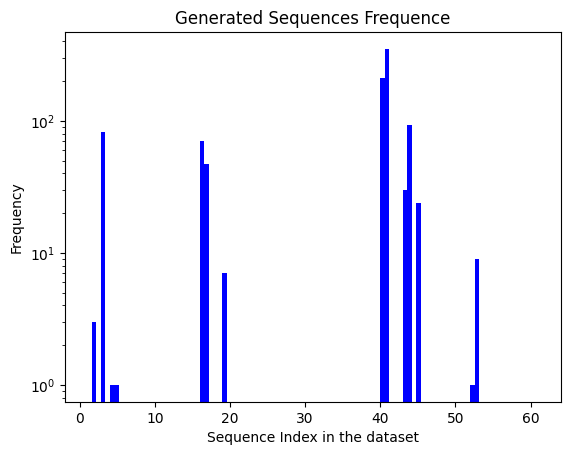

In [ ]:
########################################################################
class Sequence:
    def __init__(self, data: list) -> None:
        data = [int(x) for x in data]
        self.data = data

    def __eq__(self, rhs) -> bool:
        return self.data == rhs.data

# Mount Google Drive if your file is saved there
from google.colab import drive
drive.mount('/content/drive')

# File path to your text file
file_path = "/content/drive/MyDrive/Colab Notebooks/Copia di v_operations_2.txt"

# Read the text file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the text into a vector of Sequence
vect_seq = []
for line in lines:
    row = [int(x) for x in line.split()]
    seq = Sequence(row)
    vect_seq.append(seq)

plt.figure()
freq = []
for i in range(0, len(y_test)):
  seq = Sequence(y_test[i,:])
  if seq in vect_seq:
    freq.append(vect_seq.index(seq))
plt.hist(freq, bins=100, color='blue', range=[1,len(vect_seq)+1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Sequence Index in the dataset")
plt.title('Generated Sequences Frequence')
print(len(set(freq)))
plt.show(block=False)